# Прогнозирование оттока клиентов для  оператора связи «Ниединогоразрыва.ком»

Заказчик — Оператор связи «Ниединогоразрыва.ком».

Цель: Определить потенциальных клиентов, готовых уйти.
Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия.
Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

Необходимо: построить модель прогнозирования оттока клиентов, на основе которой будут определяться клиенты, готовые уйти. 

Для этого сперва исследуем поведение клиентов.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

#  Шаг I. Исследование оттока клиентов

### План исследования

1. Знакомство с данными

2. Обработка и подготовка данных

3. Сравним распределения величин ежемесячных платежей (MonthlyCharges) всех клиентов и тех, кто ушёл.

4. Для каждой группы посчитаем статистику: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.

5. Построим гистограмму распределения.

6. Сравним поведение клиентов этих двух групп. Для каждой построим два любых графика, изображающих:
- долю пользователей телефонной связи;
- долю интернет-пользователей.

### Импорт библиотек

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import warnings
warnings.filterwarnings('ignore')

## Знакомство с данными

### Таблица "Информация о договоре"

**Названия столбцов:**

customerID - код клиента

BeginDate - дата начала обслуживания

EndDate - дата окончания обслуживания

Type - тип договара (помесячная оплата, оплата за 1 год, оплата за 2 года)

PaperlessBilling - електронное выставление счетов

PaymentMethod - способ оплаты

MonthlyCharges - стоимость обслуживания за месяц

TotalCharges - общая стоимость обслуживания

In [3]:
contract = pd.read_csv('../../data/contract.csv')
internet = pd.read_csv('../../data/internet.csv')
personal = pd.read_csv('../../data/personal.csv')
phone = pd.read_csv('../../data/phone.csv')

In [4]:
display(contract.head(10))
contract.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Всего представлена информация о 7043 клиентах.

В столбце 'TotalCharges' обнаружены артефакты в виде пробелов. Их следует заменить. Тип данных для столбца 'TotalCharges' следует привести к числовому значению.

Других артефактов и пропусков или дубликатов в таблице не обнаружено.

Названия столбцов следует привести к змеиному регистру.

In [5]:
# переименуем столбцы, чтобы привести к корректному виду
contract = contract.rename(columns={'customerID': 'customer_id', 'BeginDate': 'begin_date', 'EndDate': 'end_date',
                        'Type': 'type', 'PaperlessBilling': 'paperless_billing', 'PaymentMethod': 'payment_method',
                        'MonthlyCharges': 'monthly_charges', 'TotalCharges': 'total_charges'})

In [6]:
display(contract.query("total_charges == ' '")) # выведем на экран строки с пустым значением в 'total_charges'

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


In [7]:
# выведем на экран уникальные значения в поле 'begin_date' для строк с пустым значением 'total_charges' 
display(contract.query("total_charges == ' '")['begin_date'].unique()) 

array(['2020-02-01'], dtype=object)

Из представленного выше анализа видно, что все строки с нулевым значением в поле 'total_charges' - это клиенты только что заключившие договор. Поэтому общую стоимость можно прировнять к месячному платежу.

In [8]:
# заменим нулевые значения в столбце с общим платежом на месячный тариф
contract.loc[contract['total_charges'] == ' ', 'total_charges'] = contract['monthly_charges'] 

In [9]:
contract['total_charges'] = contract['total_charges'].astype('float') # преобразование типа данных в столбце 'TotalCharges'

In [10]:
contract['begin_date'] = pd.to_datetime(contract['begin_date'], format='%Y-%m-%dT%H:%M:%S')

In [11]:
contract.info() # проверяем произведенные преобразования

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 440.3+ KB


### Таблица "Персональные данные клиента"

**Названия столбцов:**

customerID - код клиента

gender - пол

SeniorCitizen - наличие пенсионного статуса по возрасту

Partner - наличие супруга(и)

Dependents - наличие иждевенцев

In [12]:
display(personal.head(10))
personal.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Всего представлена информация о 7043 клиентах.

Пропусков и дубликатов в таблице не обнаружено.

Артефактов не обнаружено.

Названия столбцов следует привести к змеиному регистру.

In [13]:
# переименуем столбцы, чтобы привести к корректному виду
personal = personal.rename(columns={'customerID': 'customer_id', 'SeniorCitizen': 'senior_citizen',
                                    'Partner': 'partner', 'Dependents': 'dependents'})

### Таблица "Информация об интернет-услугах"

**Названия столбцов:**

customerID - код клиента

InternetService - интернет обслуживание

OnlineSecurity - блокировка небезопасных сайтов 

OnlineBackup - облачное хранилище файлов для резервного копирования данных

DeviceProtection - антивирус

TechSupport - выделенная линия технической поддержки

StreamingTV - стриминговое телевидение

StreamingMovies - каталог фильмов

In [14]:
display(internet.head(10))
internet.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Всего представлена информация о 5517 клиентах, что говорит о том, что интернет-услугами пользуются только 5517 клиентов из всех 7043.

Пропусков и дубликатов в таблице не обнаружено.

Артефактов не обнаружено.

Названия столбцов следует привести к змеиному регистру.

In [15]:
# переименуем столбцы, чтобы привести к корректному виду
internet = internet.rename(columns={'customerID': 'customer_id', 'InternetService': 'internet_service',
                                    'OnlineSecurity': 'online_security', 'OnlineBackup': 'online_backup',
                                    'DeviceProtection': 'device_protection', 'TechSupport': 'tech_support',
                                    'StreamingTV': 'streaming_tv', 'StreamingMovies': 'streaming_movies'})

### Таблица "Информация об услугах телефонии"

**Названия столбцов:**

customerID - код клиента

MultipleLines - наличие возможности ведения параллельных линий во время звонка

In [16]:
#phone = pd.read_csv('phone.csv')
display(phone.head(10))
phone.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Всего представлена информация о 6361 клиентах, что говорит о том, что телефонией пользуется 6361 клиент из всех 7043.

Пропусков и дубликатов в таблице не обнаружено.

Артефактов не обнаружено.

Названия столбцов следует привести к змеиному регистру.

In [17]:
# переименуем столбцы, чтобы привести к корректному виду
phone = phone.rename(columns={'customerID': 'customer_id', 'MultipleLines': 'multiple_lines'})

**Выводы:**

Данные готовы для дальнейшей работы.

## Обработка и подготовка данных

Обработаем данные для удобной работы. Объединим их в единую таблицу, предварительно дополнив информацией о клиентах, которые пользуются телефонией и аналогично интернетом. Заменим информацию в столбцах на категориальные переменные.

In [18]:
internet['internet'] = 1 # добавим столбец с информацией о подключенном интернете

phone['phone'] = 1 # добавим столбец с информацией о том, что клиент пользуется телефонией

# добавим столбец 'active' с информацией пользуется ли клиент услугами компании или ушел, где:
# No - клиент ушел
# Yes - клиент пользуется услугами до сих пор
contract.loc[contract['end_date'] != 'No', 'active'] = 'No'
contract.loc[contract['end_date'] == 'No', 'active'] = 'Yes'

# Закодируем некоторые тектовые переменные, которые можно обозначить значениями 1 и 0, например Yes=1, No=0: 
contract = contract.replace({'paperless_billing':{'Yes':1, 'No':0}})

internet = internet.replace({'online_security':{'Yes':1, 'No':0},
                             'online_backup':{'Yes':1, 'No':0},
                             'device_protection':{'Yes':1, 'No':0},
                             'tech_support':{'Yes':1, 'No':0},
                             'streaming_tv':{'Yes':1, 'No':0},
                             'streaming_movies':{'Yes':1, 'No':0}})
                                                     
personal = personal.replace({'partner':{'Yes':1, 'No':0},
                             'dependents':{'Yes':1, 'No':0}})

phone = phone.replace({'multiple_lines':{'Yes':1, 'No':0}})

# Объединим все таблицы в одну таблицу 'data'
data = contract.merge(personal, how='left').merge(internet, how='left').merge(phone, how='left')

# Заменим полученные после объединения пустые строки в столбцах 'internet' и 'phone' на 0
data = data.fillna(0)

In [19]:
data.info() # Проверим произведенные преобразования

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 23 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_id        7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           7043 non-null   object        
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   int64         
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7043 non-null   float64       
 8   active             7043 non-null   object        
 9   gender             7043 non-null   object        
 10  senior_citizen     7043 non-null   int64         
 11  partner            7043 non-null   int64         
 12  dependents         7043 non-null   int64         
 13  internet_service   7043 non-null   object        
 14  online_s

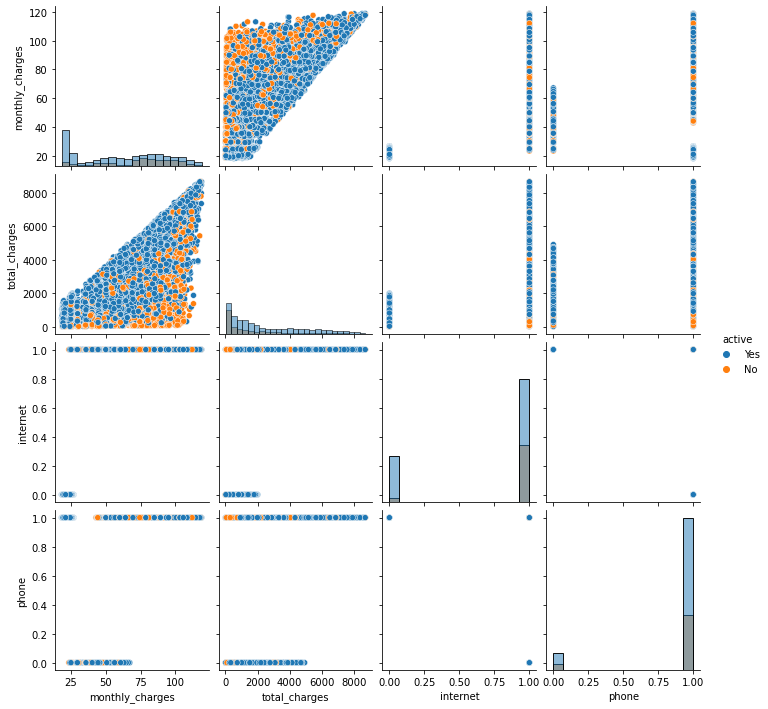

In [20]:
# рассмотрим кореляции между данными для двух групп клиентов (действующих и ушедших)
data_hist = data.drop(['internet_service', 'online_security', 'online_backup', 'multiple_lines', 'payment_method',
                         'gender', 'paperless_billing', 'device_protection', 'tech_support', 'senior_citizen',
                         'streaming_tv', 'streaming_movies', 'partner', 'dependents'], axis=1)
sns.pairplot(data_hist, hue="active", diag_kind="hist")

**Вывод:** заметна кореляция между ежемесячным платежом и платежом общим, на общем фоне выделяются расторгнувшие договор с высоким ежемесячным платежом и низкой общей стоимостью, что может говорить о том, что уходят в основном те, кто находился в обслуживании недлительное время, а среди оставшихся преобладают те, у кого ежемесячный плтеж минимальный. 

## Сравним распределения величин ежемесячных платежей (MonthlyCharges) всех клиентов и тех, кто ушёл

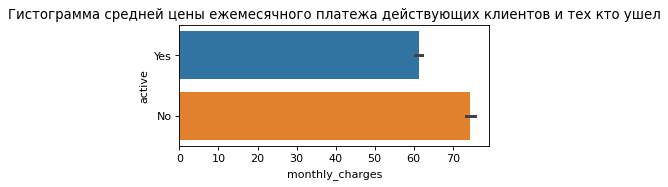

In [21]:
plt.figure(figsize=(5,2), dpi=80)
sns.barplot(y='active', x='monthly_charges', data=data)
plt.title("Гистограмма средней цены ежемесячного платежа действующих клиентов и тех кто ушел")
plt.show()

Средний чек за месяц у действующих клиентов ниже, чем у тех, кто ушел

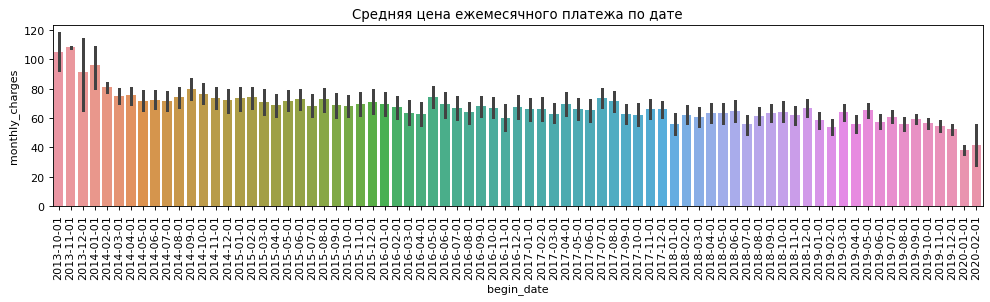

In [22]:
plt.figure(figsize=(15,3), dpi=80)
data_date = data.sort_values(by='begin_date')
data_date['begin_date'] = data_date['begin_date'].dt.strftime('%Y-%m-%d')
sns.barplot(y='monthly_charges', x='begin_date', data=data_date)
plt.xticks(rotation = 90)
plt.title("Средняя цена ежемесячного платежа по дате")
plt.show()

С годами средний ежемесячный платеж снижается

## Для каждой группы посчитаем статистику: средние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей.

In [23]:
# Cредние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей оплаты в месяц действующих клиентов
data_y = data.query("active == 'Yes'")
data_1 = data_y.pivot_table(index=['customer_id'], values='monthly_charges', aggfunc='mean')
data_1_describe = data_1.describe()
# переименуем столбец
data_1_describe = data_1_describe.rename(columns={'monthly_charges': 'current_contract'})

# Cредние, минимальные и максимальные значения, медиану и величины 25%- и 75%-квартилей оплаты в месяц ушедших клиентов
data_n = data.query("active == 'No'")
data_0 = data_n.pivot_table(index=['customer_id'], values='monthly_charges', aggfunc='mean')
data_0_describe = data_0.describe()
# переименуем столбец
data_0_describe = data_0_describe.rename(columns={'monthly_charges': 'broken_contract'})

# Объединим полученные величины в единую таблицу
data_describe = data_0_describe.join(data_1_describe, how='left')
display(data_describe)

,broken_contract,current_contract
count,1869.000000,5174.000000
mean,74.441332,61.265124
std,24.666053,31.092648
min,18.850000,18.250000
25%,56.150000,25.100000
50%,79.650000,64.425000
75%,94.200000,88.400000
max,118.350000,118.750000


Text(0.5, 1.0, 'Сравнение диаграмм размаха ежемесячных расходов для действующих клиентов и для тех, кто ушел')

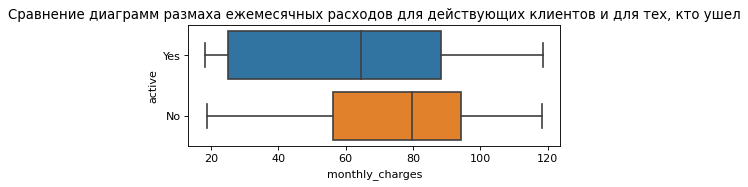

In [24]:
plt.figure(figsize=(6,2), dpi=80)
sns.boxplot(x=data['monthly_charges'], y=data['active'])

plt.title("Сравнение диаграмм размаха ежемесячных расходов для действующих клиентов и для тех, кто ушел")

По всем показателям, действующие тратят в месяц меньше, чем ушедшие.

## Построим гистограмму распределения.

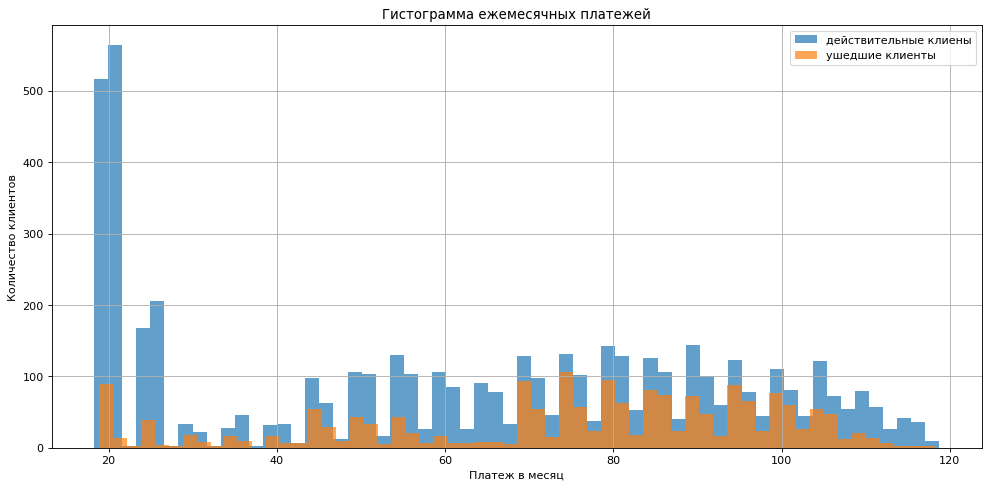

In [25]:
plt.figure(figsize=(15,7), dpi=80)
plt.hist(data_y['monthly_charges'], bins=60, alpha=0.7, label='действительные клиены')
plt.hist(data_n['monthly_charges'], bins=60, alpha=0.7, label='ушедшие клиенты')

plt.grid(True)
plt.title("Гистограмма ежемесячных платежей")
plt.legend()
plt.ylabel("Количество клиентов")
plt.xlabel("Платеж в месяц")
plt.show()

Заметно большое количество действительных клиентов, у которых ежемесячный платеж минимальный и составляет 20. Можно сказать, что доля ушедших среди тех, кто находится на минимальном тарифе, наименьшая, по сравнению с теми, кто находится на более дорогих тарифах.

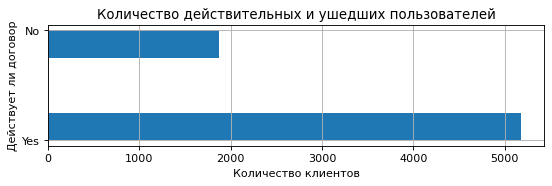

In [26]:
plt.figure(figsize=(8,2), dpi=80)
data['active'].hist(orientation='horizontal', bins=4)
plt.title("Количество действительных и ушедших пользователей")
plt.xlabel("Количество клиентов")
plt.ylabel("Действует ли договор")
plt.show()

Количество действительных клиентов более чем в 2,5 раза больше ушедших клиентов. При дальнейшем обучении модели следует это учитывать, т.к. данные несбллансированные.

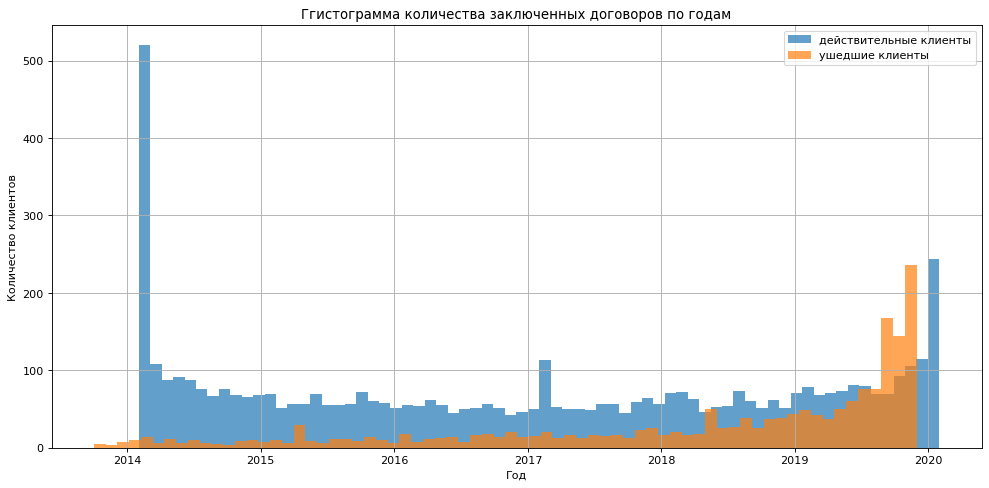

In [27]:
active = [0, 1]
plt.figure(figsize=(15,7), dpi=80)

plt.hist(data[data['active']== 'Yes']['begin_date'], bins=70, alpha=0.7, label='действительные клиенты')
plt.hist(data[data['active']== 'No']['begin_date'], bins=70, alpha=0.7, label='ушедшие клиенты')
 
plt.grid(True)
plt.title("Ггистограмма количества заключенных договоров по годам")
plt.ylabel("Количество клиентов")
plt.xlabel("Год")
plt.legend()
plt.show()

По графику видно, что клиенты стали уходить интенсивнее в последнее время. Также, заметно,  что в конце чило приходящих клиентов меньше или равно уходящим клиентам.

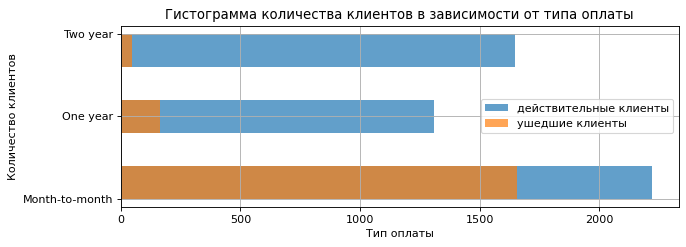

In [28]:
plt.figure(figsize=(9,3), dpi=80)

plt.hist(data[data['active']== 'Yes']['type'], bins=5, alpha=0.7,
         label='действительные клиенты', orientation='horizontal')
plt.hist(data[data['active']== 'No']['type'], bins=5, alpha=0.7,
         label='ушедшие клиенты', orientation='horizontal')
 
plt.grid(True)
plt.title("Гистограмма количества клиентов в зависимости от типа оплаты")
plt.ylabel("Количество клиентов")
plt.xlabel("Тип оплаты")
plt.legend()
plt.show()

Можно увидеть, что пользователи, которые оплачивают услуги помесячно уходят чаще.

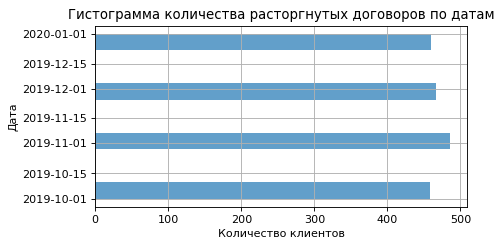

In [29]:
data_n = data.query("active == 'No'")
data_n['end_date'] = pd.to_datetime(data_n['end_date'], format='%Y-%m-%dT%H:%M:%S')

active = [0, 1]
plt.figure(figsize=(6,3), dpi=80)

plt.hist(data_n['end_date'], bins=10, alpha=0.7, orientation='horizontal')
 
plt.grid(True)
plt.title("Гистограмма количества расторгнутых договоров по датам")
plt.xlabel("Количество клиентов")
plt.ylabel("Дата")
plt.show()

Из графика расторгнутых договоров видно, что клиенты стали уходить только начиная с октября 2019. Ежемесячно производится расторжение примерно одинакового количества договоров примерно, т.е. ежемесячно уходят ориентировочно 450-480 клиентов.

## Сравним поведение клиентов этих двух групп. Для каждой построим два графика, изображающих:

- долю пользователей телефонной связи

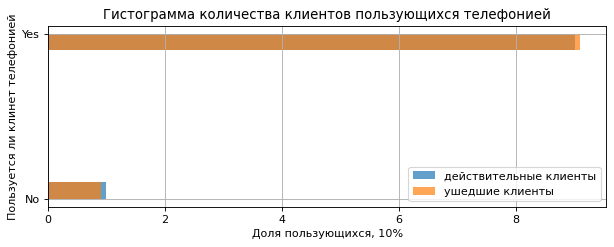

In [30]:
plt.figure(figsize=(9,3), dpi=80)

data_new = data
data_new.loc[data_new['phone'] == 0, 'phone'] = 'No'
data_new.loc[data_new['phone'] == 1, 'phone'] = 'Yes'

plt.hist(data_new[data_new['active']== 'Yes']['phone'], bins=10, alpha=0.7,
         label='действительные клиенты', orientation='horizontal', density=True)
plt.hist(data_new[data_new['active']== 'No']['phone'], bins=10, alpha=0.7,
         label='ушедшие клиенты', orientation='horizontal', density=True)
 
plt.grid(True)
plt.title("Гистограмма количества клиентов пользующихся телефонией")
plt.ylabel("Пользуется ли клинет телефонией")
plt.xlabel("Доля пользующихся, 10%")
plt.legend()
plt.show()

В обеих группах клиентов доля пользователей телефонией примерно одинаковая и составляет около 90%

- долю интернет-пользователей

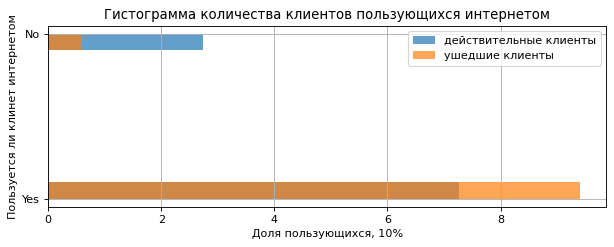

In [31]:
plt.figure(figsize=(9,3), dpi=80)

data_new = data
data_new.loc[data_new['internet'] == 0, 'internet'] = 'No'
data_new.loc[data_new['internet'] == 1, 'internet'] = 'Yes'

plt.hist(data_new[data_new['active']== 'Yes']['internet'], bins=10, alpha=0.7,
         label='действительные клиенты', orientation='horizontal', density=True)
plt.hist(data_new[data_new['active']== 'No']['internet'], bins=10, alpha=0.7,
         label='ушедшие клиенты', orientation='horizontal', density=True)
 
plt.grid(True)
plt.title("Гистограмма количества клиентов пользующихся интернетом")
plt.ylabel("Пользуется ли клинет интернетом")
plt.xlabel("Доля пользующихся, 10%")
plt.legend()
plt.show()

Среди ушедших клиентов более 90% пользователей пользовались интернет услугами, тогда как остающиехся пользователей использующих интернет только 72%

**Выводы:**

В ходе анализа данных было выявлено, что клиенты стали расторгать договор только начиная с октября 2019 года. В месяц уходит примерно 450-480 клиентов. При этом много ушедших клиентов, которые только что заключили договор.

Также видно, что на последний предоставленный период число приходящих клиентов примерно равно или меньше уходящим клиентам.

Основное различие двух рассматриваемых групп клиентов (ушедших и остающихся) в том, что средняя, максимальная и минимальная оплата за месяц сравнимо ниже у тех клиентов, кто остакется. Т.е. клиенты, которые платят много - уходят. Причины могут крыться в неудачно выбранных тарифах, отсутствия пакета услуг для тех кто много тратит трафика либо в наличии конкурентного провайдера, который за сравнимый пакет услуг предлагает мешьную стоимость.

Согласно представленным данным, пользователи, которые оплачивают услуги помесячно уходят чаще.

Среди ушедших клиентов более 93% пользователей пользовались интернет услугами, тогда как остающиехся пользователей использующих интернет только 72%.

# Шаг II. Моделирование

## Подготовка данных для обучения модели

In [32]:
# добавим дополнительный признак - продолжительность обслуживания клиента 'tenure'

current_date = '2020-02-01 00:00:00'
data.loc[data['end_date'] == 'No', 'end_date'] = current_date # заменим 'No' в столбце 'end_date' на дату предоставления данных
data['end_date'] = pd.to_datetime(data['end_date'], format='%Y-%m-%dT%H:%M:%S') # переведем тип данных 'end_date' к дате
data['tenure'] = data['end_date'] - data['begin_date'] # вычтем дату заключения договора из даты окончания договора
data['tenure']=data['tenure'].dt.days # приведем тип новых данных к числовому

# заменим нулевые значения в столбце на 30 дней
data.loc[data['tenure'] == 0, 'tenure'] = 30 

In [33]:
# отбросим лишние для работы признаки такие как общая стоимость платежей как дублирующий признак,
# даты подключения и расторжения договоров, идентификационный номер клиента 
data = data.drop(['customer_id', 'begin_date', 'end_date', 'total_charges'], axis=1) 

# закодируем целевой столбец 'active' с информацией пользуется ли клиент услугами компании или ушел, где:
# No - 1 (клиент ушел)
# Yes - 0 (клиент не ушел)
data = data.replace({'active':{'Yes':0, 'No':1}})

# закодируем оставшиеся еще незакодированные текстовые переменные
data = pd.get_dummies(data, drop_first=True)

In [34]:
display(data)

,paperless_billing,monthly_charges,active,senior_citizen,partner,dependents,online_security,online_backup,device_protection,tech_support,...,type_One year,type_Two year,payment_method_Credit card (automatic),payment_method_Electronic check,payment_method_Mailed check,gender_Male,internet_service_DSL,internet_service_Fiber optic,internet_Yes,phone_Yes
0,1,29.85,0,0,1,0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,1,0,1,0
1,0,56.95,0,0,0,0,1.0,0.0,1.0,0.0,...,1,0,0,0,1,1,1,0,1,1
2,1,53.85,1,0,0,0,1.0,1.0,0.0,0.0,...,0,0,0,0,1,1,1,0,1,1
3,0,42.30,0,0,0,0,1.0,0.0,1.0,1.0,...,1,0,0,0,0,1,1,0,1,0
4,1,70.70,1,0,0,0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1,84.80,0,0,1,1,1.0,0.0,1.0,1.0,...,1,0,0,0,1,1,1,0,1,1
7039,1,103.20,0,0,1,1,0.0,1.0,1.0,0.0,...,1,0,1,0,0,0,0,1,1,1
7040,1,29.60,0,0,1,1,1.0,0.0,0.0,0.0,...,0,0,0,1,0,0,1,0,1,0
7041,1,74.40,1,1,1,0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,1,0,1,1,1


## Разделение данных на тренировочную, валидационную и тестовую выборки

In [35]:
# Разобъем данные на выборки 60/20/20

features = data.drop(['active'], axis=1)
target = data['active']

features_train, features_temp, target_train, target_temp = train_test_split(features, target, train_size=0.6, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(features_temp, target_temp, test_size=0.5, train_size=0.5, random_state=12345)

# проверим размеры воборки
print(features_train.shape)
print(features_valid.shape)
print(features_test.shape)

(4225, 23)
(1409, 23)
(1409, 23)


In [36]:
# отмасштабируем признаки, т.к. данные в 'monthly_charges', 'tenure' сильно отличаются от прочих
numeric = ['monthly_charges', 'tenure']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

## Обучение моделей

Рассмотрим модели, которые дали наиболее качественные результаты

### Модель логистической регрессии

In [37]:
# Сперва найдем лучшие настройки для модели Логистической регрессии
model = LogisticRegression(random_state=12345, class_weight='balanced')
parametrs = {'penalty':['l2', 'l1'],
             'solver':['saga', 'sag'],
             'max_iter':[10, 100, 200]}

grid = GridSearchCV(model, parametrs, cv=5)
grid.fit(features_train, target_train)
grid.best_params_

{'max_iter': 10, 'penalty': 'l2', 'solver': 'saga'}

In [38]:
# Обучим модель Логистической регрессии
# Учтем дисбалланс классов с помощью встроенной в модель настройки

model = LogisticRegression(random_state=12345, class_weight='balanced', C=1.5375, max_iter=10, penalty='l2', solver='saga')
model.fit(features_train, target_train)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_val_lr = round(roc_auc_score(target_valid, probabilities_one_valid), 2)

print('Показание матрики AUC-ROC для валидационной выборки модели Логистической регрессии', auc_roc_val_lr)

predicted_valid = model.predict(features_valid)
acc_val_lr = round(accuracy_score(target_valid, predicted_valid), 2)
print('Показание матрики accuracy для валидационной выборки модели Логистической регрессии', acc_val_lr)

Показание матрики AUC-ROC для валидационной выборки модели Логистической регрессии 0.85
Показание матрики accuracy для валидационной выборки модели Логистической регрессии 0.76


### Модель Случайный лес

In [39]:
# Найдем лучшие параметры для модели 
model = RandomForestClassifier(random_state=12345, class_weight='balanced')
parametrs = { 'n_estimators': range (10, 51, 10),
              'max_depth': range (1,13, 2),
              'min_samples_leaf': range (1,8),
              'min_samples_split': range (2,10,2) }

grid = GridSearchCV(model, parametrs, cv=5)
grid.fit(features_train, target_train)
grid.best_params_

{'max_depth': 11,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 40}

In [40]:
# Обучим модель случайный лес
# Учтем дисбалланс классов с помощью встроенной в модель настройки

model = RandomForestClassifier(random_state=12345, class_weight='balanced', max_depth=9,
                               min_samples_leaf=4, min_samples_split=2, n_estimators=40)
model.fit(features_train, target_train)
predicted_valid =  model.predict(features_valid)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_val_rf = round(roc_auc_score(target_valid, probabilities_one_valid), 2)

print('Показание матрики AUC-ROC для валидационной выборки модели Случайный лес', auc_roc_val_rf)

probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]

predicted_valid = model.predict(features_valid)
acc_val_rf = round(accuracy_score(target_valid, predicted_valid), 2)
print('Показание матрики accuracy для валидационной выборки модели Случайный лес', acc_val_rf)

Показание матрики AUC-ROC для валидационной выборки модели Случайный лес 0.86
Показание матрики accuracy для валидационной выборки модели Случайный лес 0.78


**ВЫВОДЫ:**
Из представленных моделей наиболее высокую метрику AUC-ROC показывает модель линейной регрессии и модель случайного леса. Также, на них мною были проработаны еще два метода борьбы с дисбаллансом классов (увеличение выборки и уменьшение выборки), которые дали метрику AUC-ROC хуже встроенного инструмента борьбы с дисбаллансов в настройках модели. Во избежании лишней информации приводить эти исследования не стала.

### Модель градиентного бустинга CatBoost

In [41]:
model =  CatBoostClassifier(loss_function="Logloss", iterations=158) 

model.fit(features_train, target_train, verbose=10)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_val_cb = round(roc_auc_score(target_valid, probabilities_one_valid), 2)

print('Показание матрики AUC-ROC для валидационной выборки модели градиентного спуска CatBoost', auc_roc_val_cb)

predicted_valid = model.predict(features_valid)
acc_val_cb = round(accuracy_score(target_valid, predicted_valid), 2)
print('Показание матрики accuracy для валидационной выборки модели градиентного спуска CatBoost', acc_val_cb)


Learning rate set to 0.103513
0:	learn: 0.6223196	total: 153ms	remaining: 24s
10:	learn: 0.4142823	total: 211ms	remaining: 2.82s
20:	learn: 0.3761877	total: 257ms	remaining: 1.68s
30:	learn: 0.3604253	total: 304ms	remaining: 1.25s
40:	learn: 0.3486091	total: 353ms	remaining: 1.01s
50:	learn: 0.3389921	total: 398ms	remaining: 835ms
60:	learn: 0.3298334	total: 449ms	remaining: 714ms
70:	learn: 0.3218761	total: 497ms	remaining: 609ms
80:	learn: 0.3123777	total: 555ms	remaining: 527ms
90:	learn: 0.3033750	total: 610ms	remaining: 449ms
100:	learn: 0.2920929	total: 670ms	remaining: 378ms
110:	learn: 0.2832170	total: 732ms	remaining: 310ms
120:	learn: 0.2764951	total: 781ms	remaining: 239ms
130:	learn: 0.2700456	total: 873ms	remaining: 180ms
140:	learn: 0.2626462	total: 918ms	remaining: 111ms
150:	learn: 0.2555675	total: 976ms	remaining: 45.3ms
157:	learn: 0.2508052	total: 1.02s	remaining: 0us
Показание матрики AUC-ROC для валидационной выборки модели градиентного спуска CatBoost 0.9
Показани

### Модель градиентного бустинга LGBMClassifier

In [42]:
# Поиск лучших параметров для модели

params = {
    'max_depth': [-1, 3, 5],
    'n_estimators': [50, 100, 200, 500]}

grid = GridSearchCV(lgb.LGBMClassifier(random_state=12345), params, scoring='r2', cv=5)
grid.fit(features_train, target_train)

reg = lgb.LGBMClassifier(random_state=12345)

grid.best_params_

{'max_depth': 3, 'n_estimators': 500}

In [47]:
# Обучение модели градиентного бустинга
model = LGBMClassifier(random_state=12345, max_depth=3, n_estimators=500)
model.fit(features_train, target_train)

model.fit(features_train, target_train, verbose=10)

probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_val_lgbm = round(roc_auc_score(target_valid, probabilities_one_valid), 2)

print('Показание матрики AUC-ROC для валидационной выборки модели градиентного спуска LGBMClassifier', auc_roc_val_lgbm)

predicted_valid = model.predict(features_valid)
acc_val_lgbm = round(accuracy_score(target_valid, predicted_valid), 2)
print('Показание матрики accuracy для валидационной выборки модели градиентного спуска LGBMClassifier', acc_val_lgbm)

Показание матрики AUC-ROC для валидационной выборки модели градиентного спуска LGBMClassifier 0.91
Показание матрики accuracy для валидационной выборки модели градиентного спуска LGBMClassifier 0.85


### Дамми модель для сравнения

In [45]:
model_const = DummyClassifier(strategy="most_frequent") 
model_const.fit(features_train, target_train)

probabilities_valid = model_const.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]

auc_roc_val_const = round(roc_auc_score(target_valid, probabilities_one_valid), 2)

print('Показание матрики AUC-ROC для валидационной выборки контантной модели', auc_roc_val_const)

predicted_valid = model_const.predict(features_valid)
acc_val_const = round(accuracy_score(target_valid, predicted_valid), 2)               
print('Показание матрики accuracy для валидационной выборки константной модели', acc_val_const)

Показание матрики AUC-ROC для валидационной выборки контантной модели 0.5
Показание матрики AUC-ROC для тестовой выборки константной модели 0.5
Показание матрики accuracy для валидационной выборки константной модели 0.73
Показание матрики accuracy для тестовой выборки константной модели 0.73


## Сравним рассмотренные модели 

In [48]:
# Сравним полученные модели

models = ['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier', 'LGBMClassifier', 'DummyClassifier']
auc_roc_val = [auc_roc_val_lr, auc_roc_val_rf, auc_roc_val_cb, auc_roc_val_lgbm, auc_roc_val_const]
acc_val = [acc_val_lr, acc_val_rf, acc_val_cb, acc_val_lgbm, acc_val_const]

model_comp = pd.DataFrame({'model': models,'auc_roc_val': auc_roc_val, 'acc_val': acc_val})

display(model_comp)

,model,auc_roc_val,acc_val
0,LogisticRegression,0.85,0.76
1,RandomForestClassifier,0.86,0.78
2,CatBoostClassifier,0.90,0.84
3,LGBMClassifier,0.91,0.85
4,DummyClassifier,0.50,0.73


Модель градиентного спуска LGBMClassifier представила наиболее качественные результаты на валидационной выборке. Проверим ее работу на тестовой выборке.

### Определение матрики accuracy для тестовой выборки модели градиентного спуска LGBMClassifier

In [49]:
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc_test_lgbm = round(roc_auc_score(target_test, probabilities_one_test), 2)
print('Показание матрики AUC-ROC для тестовой выборки модели градиентного спуска LGBMClassifier', auc_roc_test_lgbm)

predicted_test = model.predict(features_test)
acc_test_lgbm = round(accuracy_score(target_test, predicted_test), 2)
print('Показание матрики accuracy для тестовой выборки модели градиентного спуска LGBMClassifier', acc_test_lgbm)

Показание матрики AUC-ROC для тестовой выборки модели градиентного спуска LGBMClassifier 0.91
Показание матрики accuracy для тестовой выборки модели градиентного спуска LGBMClassifier 0.87


## Определим степень важности представленных признаков для модели LGBM, которая показала наилучший результат по метрикам

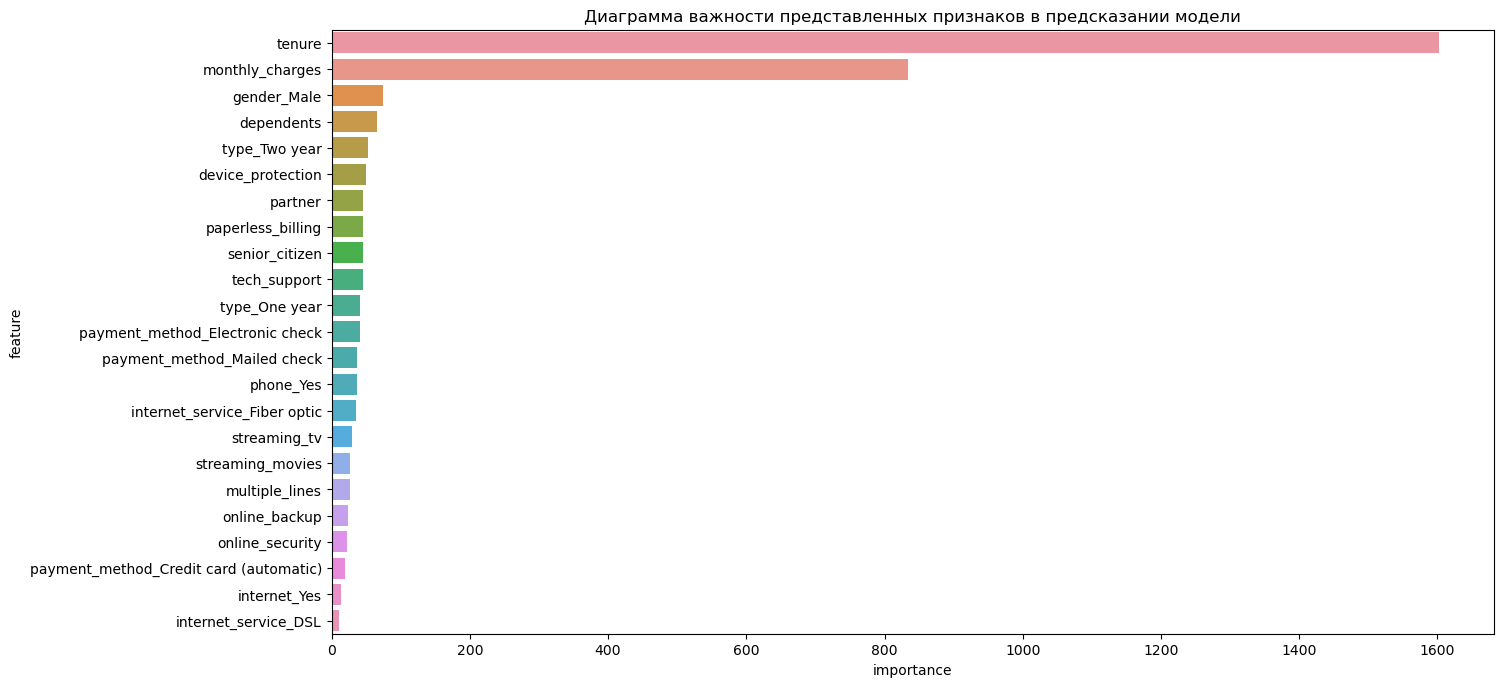

In [50]:
importances = model.feature_importances_
feature_list = list(features_train.columns)
feature_results = pd.DataFrame({'feature': feature_list,'importance': importances})
feature_results = feature_results.sort_values('importance',ascending = False).reset_index(drop=True)

plt.figure(figsize=(15,8), dpi=100)
sns.barplot(y='feature', x='importance', data=feature_results)

plt.title("Диаграмма важности представленных признаков в предсказании модели")
plt.show()

## Выводы:

Цель оператора связи «Ниединогоразрыва.ком» - получить механизм по опрелелению клиентов потенциально готовых уйти.

В связи с чем, заказчиком были предоставлены данные, на основе которых требовалось разработать модель по предсказанию парметра - уйдет ли клиент или клиент уходить не готов.

Сперва, в работе был проведен анализ данных, который показал, что клиенты стали уходить только 4 месяца назад (с октября 2019).  А также, была вявлена связь между ежемесячным платежом клиента и его способностью расторгнуть довор, т.е. чем выше ежемесячный платеж, тем выше вероятноть того, что клиент уйдет. Хотя большая часть уходящих - это те, кто заключил договор недавно, но средняя стоимость месячного обслуживания недавно заключивших договор гораздо ниже, чем у "старичков".
Длительность осблуживания, как показало дальнейшее моделирование, очень весомый фактор, который влияет на способность клиента уйти и здесь важно определить причины того, что именно послужило причиной ухода клиентов, начиная с сентября 2019 года.

Также, были выявлены другие взаимосвязи. Например, стало понятно, что среди тех, кто оплачивает услуги помесячно, вероятность уйти выше, чем среди тех, кто платит на один/два года вперед. Пользование телефонией практически не влияет на желание уйти, тогда как доля пользовавшихся интернетом гораздо выше среди ушедших, чем среди тех, кто интернернет услугами не пользуется. Хотя, пользование интернетом или телефонией не оказались весомыми факторами при моделировании.

В качестве признаков для дальнейшего обучения моделей были отобраны не все исходные данные, а именно, были исключены такие параметры как идентификационный номер клиента, дата начала договора, столбец с датой окончания договора и общая стоимость уплаченная клиентом за обслуживание.
Последние были заменены на дополнительный признак - длительность обслуживания клиента, который считается как дата начала договора минус дата окончания договора для тех кто его разорвал либо дата предоставления данных для тех кто находится в обслуживании.

Далее были рассмотрены четыре модели, из которых наиболее качественные результаты дала модель градиентного бустинга LGBMClassifier, у которой метрика AUC ROC достигает 0,91 на тестовой выборке. Для проверки моделей на адекватность в сводной таблице приведена метрика accuracy для всех моделей и для константной модели, все рассмотренные модели меют метрику accuracy выше, чем у константной.

Обученную модель LGBMClassifier можно использовать для определения потенциальных клиентов готовых уйти. Однако, стоит отметить, что в формировании новой метрики по длительности обслуживания дата предоставления данных записана в переменную 'current_date', эту переменную стоит перезаписывать каждую новую партию предоставления данных и соответсвующим образом предподготваливать признаки.

Также, сперва рекомендуем пересмотреть сетку ежемесячных тарифов для более эффективного удержания клиентов и проанализировать изменения внесенные в тарифы или политику компании начиная с сентября 2019 года, если такие были, либо определить сторонные факторы, послужившие катализатором ухода клиентов начиная с октября 2019 года. 